In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedGroupKFold,GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')  
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

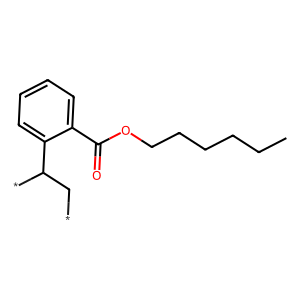

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw

mol = Chem.MolFromSmiles(train['SMILES'][0])
Draw.MolToImage(mol)

In [4]:
train.shape

(7973, 7)

In [5]:
train.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [6]:
train.isnull().sum()

id            0
SMILES        0
Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64

In [7]:
train.describe(include="all")

,id,SMILES,Tg,FFV,Tc,Density,Rg
count,7.973000e+03,7973,511.000000,7030.000000,737.000000,613.000000,614.000000
unique,NaN,7973,NaN,NaN,NaN,NaN,NaN
top,NaN,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN
mean,1.080050e+09,NaN,96.452314,0.367212,0.256334,0.985484,16.419787
std,6.218241e+08,NaN,111.228279,0.029609,0.089538,0.146189,4.608640
min,8.781700e+04,NaN,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,5.376641e+08,NaN,13.674509,0.349549,0.186000,0.890243,12.540328
50%,1.079079e+09,NaN,74.040183,0.364264,0.236000,0.948193,15.052194
75%,1.621708e+09,NaN,161.147595,0.380790,0.330500,1.062096,20.411067


In [8]:
train = train.fillna(train.median(numeric_only=True))

In [9]:
train.isnull().sum()

id         0
SMILES     0
Tg         0
FFV        0
Tc         0
Density    0
Rg         0
dtype: int64

In [10]:
train.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,74.040183,0.374645,0.205667,0.948193,15.052194
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,74.040183,0.370410,0.236000,0.948193,15.052194
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,74.040183,0.378860,0.236000,0.948193,15.052194
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,74.040183,0.387324,0.236000,0.948193,15.052194
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,74.040183,0.355470,0.236000,0.948193,15.052194


In [7]:
def get_discriptors(smile):
    chem = Chem.MolFromSmiles(smile)
    if chem is None:
        return [None] * len(desc_names)
    return [desc[1](mol) for desc in Descriptors.descList]

In [8]:
%%time

desc_names = [desc[0] for desc in Descriptors.descList]

desc_feats = [get_discriptors(smile) for smile in train['SMILES']]

descs = pd.DataFrame(desc_feats, columns=desc_names)

train = pd.concat([train, descs], axis=1)
print(train.shape)
train.head()

(7973, 215)
CPU times: user 1min 26s, sys: 101 ms, total: 1min 26s
Wall time: 1min 26s


,id,SMILES,Tg,FFV,Tc,Density,Rg,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN,12.144536,-0.105927,12.144536,...,0,0,0,0,0,0,0,0,3,0
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,12.144536,-0.105927,12.144536,...,0,0,0,0,0,0,0,0,3,0
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,12.144536,-0.105927,12.144536,...,0,0,0,0,0,0,0,0,3,0
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,12.144536,-0.105927,12.144536,...,0,0,0,0,0,0,0,0,3,0
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,12.144536,-0.105927,12.144536,...,0,0,0,0,0,0,0,0,3,0


In [9]:
desc_feats_test = [get_discriptors(smile) for smile in test['SMILES']]

descs_test = pd.DataFrame(desc_feats_test, columns=desc_names)

test = pd.concat([test, descs_test], axis=1)
print(test.shape)
test.head()

(3, 210)


,id,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1109053969,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...,12.144536,-0.105927,12.144536,0.105927,0.500278,232.323,212.163,232.14633,...,0,0,0,0,0,0,0,0,3,0
1,1422188626,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...,12.144536,-0.105927,12.144536,0.105927,0.500278,232.323,212.163,232.14633,...,0,0,0,0,0,0,0,0,3,0
2,2032016830,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...,12.144536,-0.105927,12.144536,0.105927,0.500278,232.323,212.163,232.14633,...,0,0,0,0,0,0,0,0,3,0
